In [274]:
from datasets import load_dataset
import utils
import pandas as pd
import numpy as np
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
from importlib import reload
import os
reload(utils)

<module 'utils' from '/usr/local/google/home/raulramos/projects/llmrouting/utils.py'>

In [3]:
dataset = load_dataset('databricks/databricks-dolly-15k')

Generating train split:   0%|          | 0/15011 [00:00<?, ? examples/s]

In [6]:
dataset

DatasetDict({
    train: Dataset({
        features: ['instruction', 'context', 'response', 'category'],
        num_rows: 15011
    })
})

In [25]:
tr = dataset['train']
tr = tr.to_pandas()
tr

,instruction,context,response,category
0,When did Virgin Australia start operating?,"Virgin Australia, the trading name of Virgin A...",Virgin Australia commenced services on 31 Augu...,closed_qa
1,Which is a species of fish? Tope or Rope,,Tope,classification
2,Why can camels survive for long without water?,,Camels use the fat in their humps to keep them...,open_qa
3,"Alice's parents have three daughters: Amy, Jes...",,The name of the third daughter is Alice,open_qa
4,When was Tomoaki Komorida born?,Komorida was born in Kumamoto Prefecture on Ju...,"Tomoaki Komorida was born on July 10,1981.",closed_qa
...,...,...,...,...
15006,How do i accept the change,,Embrace the change and see the difference,brainstorming
15007,What is a laser and who created it?,A laser is a device that emits light through a...,A laser is a device that emits light from an e...,summarization
15008,What is the difference between a road bike and...,,Road bikes are built to be ridden on asphalt a...,open_qa
15009,How does GIS help in the real estate investmen...,,"Real estate investors depend on precise, accur...",general_qa


In [106]:
tr.category.iloc[:1000].value_counts()

category
open_qa                   242
general_qa                162
classification            137
closed_qa                 122
brainstorming             118
information_extraction     90
summarization              79
creative_writing           50
Name: count, dtype: int64

In [107]:
texts = (tr.context + '\n----\n'+ tr.instruction).values
print (texts[0])

Virgin Australia, the trading name of Virgin Australia Airlines Pty Ltd, is an Australian-based airline. It is the largest airline by fleet size to use the Virgin brand. It commenced services on 31 August 2000 as Virgin Blue, with two aircraft on a single route. It suddenly found itself as a major airline in Australia's domestic market after the collapse of Ansett Australia in September 2001. The airline has since grown to directly serve 32 cities in Australia, from hubs in Brisbane, Melbourne and Sydney.
----
When did Virgin Australia start operating?


In [433]:
reload(utils)
te = utils.GenAI(project='genai-dev-454121', location='us-central1')

#te = utils.GenAI(project='genai-dev-454121', location="us-east5")

In [446]:
models = ["gemini-2.5-flash-preview-05-20",
          'meta/llama-4-scout-17b-16e-instruct-maas'][::-1]

if os.path.isfile('dolly_15k_extended.h5'):
    sampled_tr = pd.read_hdf('dolly_15k_extended.h5')
    print ('reading file')
else:
    sampled_tr = tr.sample(100).copy()
    sampled_tr = tr.copy()

for model in models:
    if not f"{model}::response" in sampled_tr.columns:
        sampled_tr[f"{model}::response"] = ""
        sampled_tr[f"{model}::code"] = "pending"

    sampled_tr[f"{model}::code"] = ['pending' if i[f"{model}::response"] is None or 'RESOURCE_EXHAUSTED' in i[f"{model}::response"] or i[f"{model}::code"] == 'ServerError' else i[f"{model}::code"] for _,i in sampled_tr.iterrows()]



reading file


In [447]:
for m in models:
    print(sampled_tr[f'{m}::code'].value_counts())

meta/llama-4-scout-17b-16e-instruct-maas::code
ok    15011
Name: count, dtype: int64
gemini-2.5-flash-preview-05-20::code
ok    15011
Name: count, dtype: int64


In [449]:
texts = (sampled_tr.context + '\n----\n'+ sampled_tr.instruction).values
embs = te.get_embeddings(texts)
sampled_tr['text_embeddings'] = list(embs)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   37.2s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 2162 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed:  9.6min
[Parallel(n_jobs=-1)]: Done 3026 tasks      | elapsed: 11.2min
[Parallel(n_jobs=-1)]: Done 3512 tasks      | elapsed: 13.0min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | ela

In [450]:
sampled_tr.to_hdf('dolly_15k_extended.h5', key='main')


/tmp/ipykernel_1380478/428234571.py:1: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block0_values] [items->Index(['instruction', 'context', 'response', 'category',
       'gemini-2.5-flash-preview-05-20::response',
       'gemini-2.5-flash-preview-05-20::code',
       'meta/llama-4-scout-17b-16e-instruct-maas::response',
       'meta/llama-4-scout-17b-16e-instruct-maas::code', 'text_embeddings'],
      dtype='object')]

  sampled_tr.to_hdf('dolly_15k_extended.h5', key='main')


In [431]:
df = sampled_tr.copy()
models

['meta/llama-4-scout-17b-16e-instruct-maas', 'gemini-2.5-flash-preview-05-20']

In [442]:

for model in models[1:]:
    print (model, flush=True)
    col_code = f"{model}::code"
    col_response = f"{model}::response"
        
    while (sum(df[col_code]=='pending')>0):
        df_ok      = df[df[col_code]=='ok'].copy()
        df_pending = df[df[col_code]=='pending'].copy()
        df_rest    = df[~df[col_code].isin(['ok', 'pending'])].copy()
        
        print (f'  ok {len(df_ok)}, pending {len(df_pending)}, rest {len(df_rest)}', flush=True)  

        texts = (df_pending.context + '\n----\n'+ df_pending.instruction).values
        contents = pd.DataFrame(te.generate_contents(model=model, list_of_texts=texts, sleep_time=1))
        df_pending[col_response] = contents['response'].values
        df_pending[col_code] = contents['code'].values
        df_pending[col_code] = ['pending' if (i[col_response] is None or 'RESOURCE_EXHAUSTED' in i[col_response] or i[col_code] == 'RefreshError') \
                                          else i[f"{model}::code"] for _,i in df_pending.iterrows()]

        df = pd.concat([df_ok, df_pending, df_rest])
        df.to_hdf('dolly_15k_extended.h5', key='main')


gemini-2.5-flash-preview-05-20


In [445]:
df.sample(3000).to_hdf('dolly_15k_extended_small_3k.h5', key='main')


# Clustering

In [132]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

In [125]:
n_classes = len(np.unique(sampled_tr.category.values))
c = KMeans(n_clusters=n_classes).fit_predict(embs)


In [126]:
pd.crosstab(sampled_tr.category.values, c)

col_0,0,1,2,3,4,5,6,7
row_0,,,,,,,,
brainstorming,5,152,29,12,2,285,44,61
classification,2,6,20,506,98,17,1,70
closed_qa,514,1,21,0,3,1,14,2
creative_writing,1,123,14,5,0,85,0,9
general_qa,6,22,170,11,2,411,3,117
information_extraction,299,1,13,1,0,0,195,2
open_qa,16,10,348,13,4,243,8,616
summarization,323,1,23,0,0,0,38,1


In [133]:
embs_tsne = TSNE().fit_transform(embs)

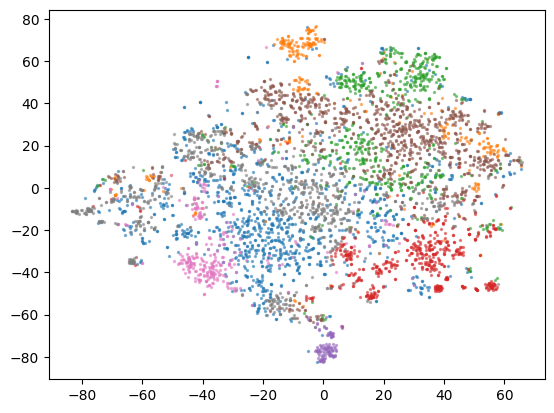

In [139]:
embs_tsne = TSNE().fit_transform(embs)for i in range(8):
    _x = embs_tsne[c==i]
    plt.scatter(_x[:,0], _x[:,1], s=2, alpha=.5)

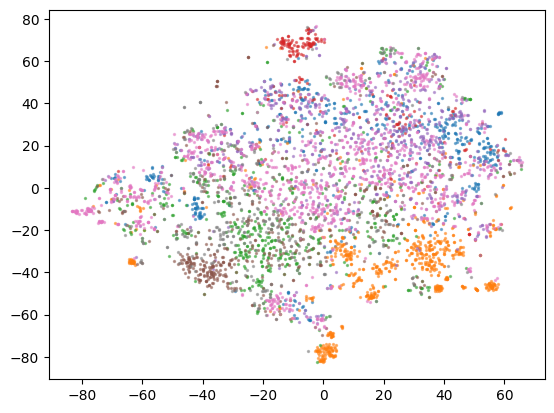

In [140]:
classes = np.unique(sampled_tr.category.values)
for i in classes:
    _x = embs_tsne[sampled_tr.category.values==i]
    plt.scatter(_x[:,0], _x[:,1], s=2, alpha=.5)

In [136]:
c

array([7, 6, 0, ..., 5, 0, 0], dtype=int32)

In [131]:
client = te.client

In [129]:
response = client.models.generate_content(
    model="gemini-2.5-flash-preview-05-20",
    contents="How does AI work?",
)

In [130]:
response.text

'At its core, **Artificial Intelligence (AI)** works by enabling computers to **learn from data** and then use that learning to **make decisions or predictions**, or to perform tasks that typically require human intelligence.\n\nThink of it like teaching a child:\n\n1.  **Showing Examples (Data):** You show a child many pictures of cats and dogs, pointing out which is which. In AI, this is providing a computer with a **large dataset** (e.g., millions of images, text documents, or numbers). This data is often "labeled" so the AI knows what it\'s looking at initially.\n\n2.  **Learning the Rules (Algorithms & Models):** The child slowly starts to understand what makes a cat a cat (pointy ears, whiskers, meows) and a dog a dog (floppy ears, barks, wags tail). In AI, this is where **algorithms** come in. These are sets of rules or instructions that the computer uses to analyze the data and **find patterns and relationships** within it. The "learning" process involves the algorithm adjustin